<a href="https://colab.research.google.com/github/shiri9/non-iid/blob/main/label_skew_statitistical-dirichlet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install TensorFlow and all dependencies explicitly compatible with TFF 0.87.0
%pip install tensorflow==2.15.0
%pip install tensorflow-federated==0.81.0
%pip install tensorflow-privacy==0.9.0
%pip install tensorflow-model-optimization==0.7.5
%pip install jax==0.4.14 jaxlib==0.4.14
%pip install google-vizier==0.1.11
%pip install dp-accounting==0.4.3
%pip install portpicker==1.6.0
%pip install scipy==1.9.3
%pip install numpy==1.25.2
%pip install protobuf==3.20.3
%pip install typing-extensions==4.7.1
%pip install googleapis-common-protos==1.61.0
%pip install dm-tree==0.1.8

  Using cached tensorflow_federated-0.81.0-py3-none-manylinux_2_31_x86_64.whl.metadata (2.2 kB)
  Using cached attrs-23.2.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached dm_tree-0.1.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.9 kB)
  Using cached dp_accounting-0.4.3-py3-none-any.whl.metadata (1.8 kB)
  Using cached google_vizier-0.1.11-py3-none-any.whl.metadata (10 kB)
  Using cached jaxlib-0.4.14-cp311-cp311-manylinux2014_x86_64.whl.metadata (2.0 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 4.3 MB/s eta 0:00:00
  Using cached attrs-23.1.0-py3-none-any.whl.metadata (11 kB)
  Using cached grpcio_tools-1.71.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.3 kB)
  Using cached SQLAlchemy-1.4.20.tar.gz (7.

^C
^C
^C
^C


In [1]:
!python --version

Python 3.11.12


In [2]:
!rm -rf /usr/local/lib/python3.11/dist-packages/jax_plugins

In [3]:
# Verify
import tensorflow as tf
import tensorflow_federated as tff

print("TF version:", tf.__version__)
print("TFF version:", tff.__version__)

TF version: 2.14.1
TFF version: 0.81.0


In [4]:
#cell 1
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from google.colab import drive

# Mount Google Drive to access data files
drive.mount('/content/drive')

# Load datasets
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kdd_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kdd_test.csv')

# Define label mapping for attack categories (including all labels from train and test sets)
attack_mapping = {
    'normal': 0, 'neptune': 1, 'land': 1, 'back': 1, 'teardrop': 1, 'pod': 1, 'smurf': 1,
    'ipsweep': 2, 'nmap': 2, 'portsweep': 2, 'satan': 2,
    'mailbomb': 1, 'apache2': 1, 'processtable': 1,  # Missing DoS labels in test set
    'phf': 3, 'multihop': 3, 'warezclient': 3, 'warezmaster': 3, 'spy': 3, 'ftp_write': 3,
    'guess_passwd': 3, 'imap': 3,
    'buffer_overflow': 4, 'loadmodule': 4, 'perl': 4, 'rootkit': 4,
    # Ensure all test labels are included
    'mscan': 2, 'saint': 2, 'snmpgetattack': 3, 'snmpguess': 3, 'xlock': 3, 'xsnoop': 3,
    'httptunnel': 3, 'ps': 4, 'xterm': 4,
    'sendmail': 3, 'named': 3  # Missing labels in test set
}

# Apply the label mapping
df_train['labels'] = df_train['labels'].replace(attack_mapping)
df_test['labels'] = df_test['labels'].replace(attack_mapping)

# Verify the unique labels after mapping
print("Unique labels in train set:", df_train['labels'].unique())
print("Unique labels in test set:", df_test['labels'].unique())

# Dropping the irrelevant column 'num_outbound_cmds'
df_train = df_train.drop('num_outbound_cmds', axis=1)
df_test = df_test.drop('num_outbound_cmds', axis=1)

# Encoding categorical columns: 'protocol_type', 'service', 'flag'
categorical_columns = ['protocol_type', 'service', 'flag']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.transform(df_test[col])  # Important: use transform for test set, not fit_transform

# Scaling numerical columns
numerical_columns = [
    'duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'hot', 'num_compromised', 'num_root'
]

scaler = MinMaxScaler()
df_train[numerical_columns] = scaler.fit_transform(df_train[numerical_columns])
df_test[numerical_columns] = scaler.transform(df_test[numerical_columns])

# Convert to NumPy arrays and enforce correct types for TensorFlow
X_train = np.array(df_train.drop('labels', axis=1)).astype(np.float32)
y_train = np.array(df_train['labels']).astype(np.int32)

X_test = np.array(df_test.drop('labels', axis=1)).astype(np.float32)
y_test = np.array(df_test['labels']).astype(np.int32)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# Check dataset shapes
print("Train dataset shape:", X_train.shape, y_train.shape)
print("Test dataset shape:", X_test.shape, y_test.shape)

Mounted at /content/drive


<ipython-input-4-43537eeb4cce>:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['labels'] = df_train['labels'].replace(attack_mapping)
<ipython-input-4-43537eeb4cce>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['labels'] = df_test['labels'].replace(attack_mapping)


Unique labels in train set: [0 1 3 2 4]
Unique labels in test set: [0 2 1 3 4]
Train dataset shape: (125973, 40) (125973,)
Test dataset shape: (22544, 40) (22544,)


In [5]:
# ## Cell2: Create Non-IID Partitions with Dirichlet Label Skew (Modified Version)

import numpy as np
import pandas as pd

# Configuration
NUM_CLIENTS = 10
NUM_CLASSES = 5  # Based on your 5 attack categories (0-4)
ALPHA = 0.5      # Dirichlet concentration parameter (α=0.5 for moderate skew)
SEED = 42        # For reproducibility
MIN_SAMPLES_PER_CLIENT = 100  # Ensure clients have sufficient data

np.random.seed(SEED)  # Fix randomness for reproducibility

# Step 1: Generate client-specific label distributions using Dirichlet
client_label_probs = np.random.dirichlet([ALPHA]*NUM_CLASSES, size=NUM_CLIENTS)

# Initialize list to store partitions
data_partitions = []

# Create partitions using Dirichlet distributions
for client_id in range(NUM_CLIENTS):
    partition = pd.DataFrame()
    client_probs = client_label_probs[client_id]  # Probability vector for this client

    # For each class, sample data proportionally to Dirichlet probabilities
    for label in range(NUM_CLASSES):
        class_data = df_train[df_train['labels'] == label]
        if len(class_data) == 0:
            continue  # Skip empty classes

        # Calculate number of samples for this class
        num_samples = max(
            MIN_SAMPLES_PER_CLIENT // NUM_CLASSES,  # Minimum guarantee
            int(len(class_data) * client_probs[label])  # Dirichlet proportion
        )

        # Sample without replacement
        sampled_data = class_data.sample(n=num_samples, replace=False, random_state=SEED+client_id)
        partition = pd.concat([partition, sampled_data])

    # Final checks
    if len(partition) == 0:
        raise ValueError(f"Client {client_id} has no data!")

    # Shuffle and store
    data_partitions.append(
        partition.sample(frac=1, random_state=SEED).reset_index(drop=True)
    )

    # Print verification
    print(f"\nClient {client_id+1} Label Distribution (Dirichlet α={ALPHA}):")
    print(partition['labels'].value_counts().sort_index())
    print(f"Target distribution: {np.round(client_probs, 2)}")

print("\nSuccessfully created Dirichlet-based non-IID partitions!")



Client 1 Label Distribution (Dirichlet α=0.5):
labels
0     7854
1    25164
2      235
3       20
4       20
Name: count, dtype: int64
Target distribution: [0.12 0.55 0.02 0.   0.31]

Client 2 Label Distribution (Dirichlet α=0.5):
labels
0       20
1    35730
2      273
3       65
4       20
Name: count, dtype: int64
Target distribution: [0.   0.78 0.02 0.07 0.13]

Client 3 Label Distribution (Dirichlet α=0.5):
labels
0    23786
1     3526
2     2181
3       35
4       20
Name: count, dtype: int64
Target distribution: [0.35 0.08 0.19 0.04 0.35]

Client 4 Label Distribution (Dirichlet α=0.5):
labels
0       70
1    38573
2      268
3      131
4       20
Name: count, dtype: int64
Target distribution: [0.   0.84 0.02 0.13 0.  ]

Client 5 Label Distribution (Dirichlet α=0.5):
labels
0     20
1    754
2    277
3     73
4     46
Name: count, dtype: int64
Target distribution: [0.   0.02 0.02 0.07 0.89]

Client 6 Label Distribution (Dirichlet α=0.5):
labels
0    55215
1     5767
2       30
3 

In [6]:

# ## Cell3: Create Label-Skew Partitions

import numpy as np
import pandas as pd

# Configuration
NUM_CLIENTS = 10
CLASS_MAPPING = {'Benign': 0, 'DoS': 1, 'Probe': 2, 'U2R': 3, 'R2L': 4}
MIN_SAMPLES_PER_CLASS = 50  # Prevent class starvation

# Label distribution per client (matches your paper's setup)
client_class_map = {
    0: ['Benign', 'DoS'],
    1: ['Benign', 'Probe'],
    2: ['Benign', 'U2R'],
    3: ['Benign', 'R2L'],
    4: ['DoS', 'Probe'],
    5: ['DoS', 'U2R'],
    6: ['DoS', 'R2L'],
    7: ['Probe', 'U2R'],
    8: ['Probe', 'R2L'],
    9: ['U2R', 'R2L']
}

data_partitions = []
for client_id in range(NUM_CLIENTS):
    client_partition = pd.DataFrame()
    classes = client_class_map[client_id]

    for class_name in classes:
        label = CLASS_MAPPING[class_name]
        class_data = df_train[df_train['labels'] == label]

        # Dynamic sampling with minimum guarantee
        proportion = np.random.uniform(0.1, 0.4)  # 10-40% of class data
        num_samples = max(MIN_SAMPLES_PER_CLASS, int(len(class_data) * proportion))

        client_partition = pd.concat([
            client_partition,
            class_data.sample(n=num_samples, random_state=42+client_id)
        ])

    # Shuffle and store
    data_partitions.append(
        client_partition.sample(frac=1, random_state=42).reset_index(drop=True)
    )

    # Verification
    print(f"\nClient {client_id+1} Distribution:")
    print(client_partition['labels'].value_counts().sort_index())


Client 1 Distribution:
labels
0    15025
1    15002
Name: count, dtype: int64

Client 2 Distribution:
labels
0    11356
2     1434
Name: count, dtype: int64

Client 3 Distribution:
labels
0    12588
3      147
Name: count, dtype: int64

Client 4 Distribution:
labels
0    25516
4       50
Name: count, dtype: int64

Client 5 Distribution:
labels
1    13319
2     4212
Name: count, dtype: int64

Client 6 Distribution:
labels
1    15665
3      155
Name: count, dtype: int64

Client 7 Distribution:
labels
1    16890
4       50
Name: count, dtype: int64

Client 8 Distribution:
labels
2    3989
3     366
Name: count, dtype: int64

Client 9 Distribution:
labels
2    2277
4      50
Name: count, dtype: int64

Client 10 Distribution:
labels
3    167
4     50
Name: count, dtype: int64


In [7]:

# ## Cell4 : Create TensorFlow Datasets (Final Corrected Version)

import numpy as np
import tensorflow as tf

# Configuration
batch_size = 32
SEED = 42  # For reproducible shuffling

train_datasets = []
val_datasets = []

for client_id, partition in enumerate(data_partitions):
    # ========== Exact 90/10 Split ==========
    total_samples = len(partition)
    train_samples = (total_samples // 10) * 9  # Exact 90%
    val_samples = total_samples - train_samples  # Exact 10%

    # Shuffle with client-specific seed
    shuffled_partition = partition.sample(frac=1, random_state=SEED+client_id).reset_index(drop=True)

    # Split into train/val
    train_part = shuffled_partition.iloc[:train_samples]
    val_part = shuffled_partition.iloc[train_samples:]

    # ========== Feature/Label Conversion ==========
    # Training data
    train_features = train_part.drop(columns=['labels']).values.astype(np.float32)
    train_labels = train_part['labels'].values.astype(np.int32)

    # Validation data
    val_features = val_part.drop(columns=['labels']).values.astype(np.float32)
    val_labels = val_part['labels'].values.astype(np.int32)

    # ========== Dataset Creation ==========
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (train_features, train_labels)
    ).batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices(
        (val_features, val_labels)
    ).batch(batch_size)

    # Store datasets
    train_datasets.append(train_dataset)
    val_datasets.append(val_dataset)

    # ========== Verification ==========
    print(f"Client {client_id+1}:")
    print(f"  Train: {len(train_part)} samples | Classes: {np.unique(train_labels)}")
    print(f"  Val: {len(val_part)} samples | Classes: {np.unique(val_labels)}\n")

# ========== Test Dataset ==========
test_features = df_test.drop(columns=['labels']).values.astype(np.float32)
test_labels = df_test['labels'].values.astype(np.int32)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_features, test_labels)
).batch(batch_size)

print("=== Final Verification ===")
print(f"Total training clients: {len(train_datasets)}")
print(f"Test samples: {len(test_labels)}")
print(f"Test features shape: {test_features.shape}")

Client 1:
  Train: 27018 samples | Classes: [0 1]
  Val: 3009 samples | Classes: [0 1]

Client 2:
  Train: 11511 samples | Classes: [0 2]
  Val: 1279 samples | Classes: [0 2]

Client 3:
  Train: 11457 samples | Classes: [0 3]
  Val: 1278 samples | Classes: [0 3]

Client 4:
  Train: 23004 samples | Classes: [0 4]
  Val: 2562 samples | Classes: [0 4]

Client 5:
  Train: 15777 samples | Classes: [1 2]
  Val: 1754 samples | Classes: [1 2]

Client 6:
  Train: 14238 samples | Classes: [1 3]
  Val: 1582 samples | Classes: [1 3]

Client 7:
  Train: 15246 samples | Classes: [1 4]
  Val: 1694 samples | Classes: [1 4]

Client 8:
  Train: 3915 samples | Classes: [2 3]
  Val: 440 samples | Classes: [2 3]

Client 9:
  Train: 2088 samples | Classes: [2 4]
  Val: 239 samples | Classes: [2 4]

Client 10:
  Train: 189 samples | Classes: [3 4]
  Val: 28 samples | Classes: [3 4]

=== Final Verification ===
Total training clients: 10
Test samples: 22544
Test features shape: (22544, 40)


In [ ]:

# ## Cell5: Centralized Training (Label Skew Version)

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def centralized_training(seed=42):
    tf.keras.utils.set_random_seed(seed)

    # 1. Combine all client partitions (NEW FOR LABEL SKEW)
    full_train = pd.concat(data_partitions).sample(frac=1, random_state=seed)
    full_train_features = full_train.drop('labels', axis=1).values.astype(np.float32)
    full_train_labels = full_train['labels'].values.astype(np.int32)

    # 2. Create model (same architecture as FL)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(40,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    # 3. Training with metrics tracking
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    history = model.fit(
        full_train_features, full_train_labels,
        epochs=30,
        batch_size=32,
        validation_data=(test_features, test_labels),  # Use your existing test data
        verbose=0
    )

    # 4. Final evaluation
    y_pred = np.argmax(model.predict(test_features), axis=1)

    return {
        'seed': seed,
        'train_loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
        'test_accuracy': history.history['val_accuracy'][-1],
        'test_precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'test_recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'test_f1': f1_score(y_test, y_pred, average='macro', zero_division=0)
    }

# Run with multiple seeds
results_cl = [centralized_training(seed=s) for s in [42, 123, 456]]

# Generate report
report_cl = pd.DataFrame(results_cl)
print("\nCentralized Training Results (Label Skew Scenario):")
display(report_cl[['seed', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']])

In [6]:
# ## Cell6: Federated Learning with Statistical Significance
import tensorflow as tf
import tensorflow_federated as tff
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import collections
from scipy import stats

# ======================
# 1. Data Preprocessing
# ======================

def preprocess(dataset):
    def batch_format_fn(features, labels):
        return collections.OrderedDict(
            x=tf.reshape(features, [-1, 40]),  # Flatten features
            y=tf.reshape(labels, [-1])  # Reshape labels
        )
    padded_shapes = ([None, 40], [None])
    return dataset.padded_batch(32, padded_shapes=padded_shapes).map(batch_format_fn).prefetch(tf.data.experimental.AUTOTUNE)

# ======================
# 2. Core FL Functions
# ======================

def create_keras_model():
    return tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(40,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

def make_federated_data(client_data, client_ids):
    """Global function to create federated datasets"""
    return [
        preprocess(client_data[i])
        for i in client_ids
        if len(list(client_data[i])) > 0  # Filter empty datasets
    ]

def run_fl_trial(seed=42, num_rounds=30):
    """Run complete FL pipeline with specified seed"""
    # Set all seeds
    tf.keras.utils.set_random_seed(seed)
    np.random.seed(seed)

    # Model function
    def model_fn():
        return tff.learning.models.from_keras_model(
            create_keras_model(),
            input_spec=federated_train_data[0].element_spec,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
        )

    # Build training process
    training_process = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.Adam(0.001),
        server_optimizer_fn=lambda: tf.keras.optimizers.Adam(0.01)
    )

    # Training loop
    state = training_process.initialize()
    for _ in range(num_rounds):
        state = training_process.next(state, federated_train_data).state

    # Evaluation
    eval_model = create_keras_model()
    eval_model.set_weights(list(training_process.get_model_weights(state).trainable))
    y_pred = np.argmax(eval_model.predict(test_features), axis=1)


    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'f1': f1_score(y_test, y_pred, average='macro', zero_division=0)
    }

# ======================
# 3. Execution & Analysis
# ======================

# Configuration
NUM_CLIENTS = 10
SEEDS = [42, 123, 456]

# Create federated data (ensure train_datasets exists)
federated_train_data = make_federated_data(train_datasets, list(range(NUM_CLIENTS)))

# Run trials
fl_results = [run_fl_trial(seed=s) for s in SEEDS]

# Statistical comparison with centralized results (assuming results_cl exists)
def print_stat_comparison(cl_results, fl_results):
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        cl_values = [r[f'test_{metric}'] for r in cl_results]
        fl_values = [r[metric] for r in fl_results]
        t_stat, p_value = stats.ttest_ind(cl_values, fl_values)

        print(f"\n{metric.upper():<10} CL: {np.mean(cl_values):.4f} ± {np.std(cl_values):.4f}")
        print(f"{'FL:':<10} {np.mean(fl_values):.4f} ± {np.std(fl_values):.4f}")
        print(f"{'p-value:':<10} {p_value:.4e}{'*' if p_value < 0.05 else ''}")

print("\n=== Statistical Significance ===")
print_stat_comparison(results_cl, fl_results)

705/705 [==============================] - 1s 2ms/step

=== Statistical Significance ===

ACCURACY   CL: 0.9294 ± 0.0036
FL:        0.8395 ± 0.0114
p-value:   4.3965e-04*

PRECISION  CL: 0.9069 ± 0.0399
FL:        0.4738 ± 0.0906
p-value:   3.4658e-03*

RECALL     CL: 0.6959 ± 0.0223
FL:        0.4063 ± 0.0186
p-value:   1.4659e-04*

F1         CL: 0.7386 ± 0.0223
FL:        0.3991 ± 0.0293
p-value:   1.9983e-04*


In [7]:
import numpy as np
unique_labels, counts = np.unique(y_test, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Class {label}: {count} samples ({count/len(y_test):.1%})")

Class 0: 11245 samples (49.9%)
Class 1: 8095 samples (35.9%)
Class 2: 2157 samples (9.6%)
Class 3: 1009 samples (4.5%)
Class 4: 38 samples (0.2%)


In [9]:
# ## Cell5: Enhanced Centralized Training with Full Metrics
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

def centralized_training(seed=42, epochs=30):
    tf.keras.utils.set_random_seed(seed)

    # 1. Combine all client data
    full_train = pd.concat(data_partitions).sample(frac=1, random_state=seed)
    X_train = full_train.drop('labels', axis=1).values.astype(np.float32)
    y_train = full_train['labels'].values.astype(np.int32)

    # 2. Model definition
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(40,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # 3. Custom callback for metrics
    class CLMetrics(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            # Test set evaluation
            y_pred = np.argmax(model.predict(test_features), axis=1)
            logs['test_precision'] = precision_score(y_test, y_pred, average='macro', zero_division=0)
            logs['test_recall'] = recall_score(y_test, y_pred, average='macro', zero_division=0)
            logs['test_f1'] = f1_score(y_test, y_pred, average='macro', zero_division=0)

            # Interval reporting
            if (epoch+1) % 5 == 0:
                print(f"\nEpoch {epoch+1}/{epochs}:")
                print(f"Train Loss: {logs['loss']:.4f} | Test Loss: {logs['val_loss']:.4f}")
                print(f"Accuracy: {logs['val_accuracy']:.4f} | F1: {logs['test_f1']:.4f}")

    # 4. Training
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(test_features, test_labels),
        callbacks=[CLMetrics()],
        verbose=0
    )

    # 5. Calculate RMSE
    train_rmse = np.sqrt(np.mean(np.square(history.history['loss'])))
    test_rmse = np.sqrt(np.mean(np.square(history.history['val_loss'])))

    return {
        'train_loss': history.history['loss'],
        'test_loss': history.history['val_loss'],
        'test_accuracy': history.history['val_accuracy'],
        'test_precision': [history.history[f'test_precision'][i] for i in range(epochs)],
        'test_recall': [history.history[f'test_recall'][i] for i in range(epochs)],
        'test_f1': [history.history[f'test_f1'][i] for i in range(epochs)],
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
    }

# Run centralized training
cl_results = centralized_training()
print(f"\nFinal RMSE - Train: {cl_results['train_rmse']:.4f}, Test: {cl_results['test_rmse']:.4f}")

705/705 [==============================] - 1s 2ms/step

Epoch 5/30:
Train Loss: 0.0266 | Test Loss: 0.6592
Accuracy: 0.9186 | F1: 0.7217
705/705 [==============================] - 1s 1ms/step

Epoch 10/30:
Train Loss: 0.0188 | Test Loss: 0.7648
Accuracy: 0.9239 | F1: 0.7195
705/705 [==============================] - 1s 2ms/step

Epoch 15/30:
Train Loss: 0.0147 | Test Loss: 0.6757
Accuracy: 0.9233 | F1: 0.7325
705/705 [==============================] - 1s 1ms/step

Epoch 20/30:
Train Loss: 0.0130 | Test Loss: 0.9732
Accuracy: 0.9259 | F1: 0.7062
705/705 [==============================] - 1s 1ms/step

Epoch 25/30:
Train Loss: 0.0119 | Test Loss: 0.9634
Accuracy: 0.9283 | F1: 0.7440
705/705 [==============================] - 1s 1ms/step

Epoch 30/30:
Train Loss: 0.0115 | Test Loss: 1.0644
Accuracy: 0.9268 | F1: 0.7336

Final RMSE - Train: 0.0270, Test: 0.8272


705/705 [==============================] - 1s 1ms/step

=== Statistical Significance ===

ACCURACY   CL: 0.9276 ± 0.0012
FL:        0.8405 ± 0.0129
p-value:   6.7194e-04*

PRECISION  CL: 0.9017 ± 0.0400
FL:        0.4762 ± 0.0926
p-value:   3.9688e-03*

RECALL     CL: 0.6916 ± 0.0065
FL:        0.4118 ± 0.0264
p-value:   1.2920e-04*

F1         CL: 0.7324 ± 0.0125
FL:        0.4071 ± 0.0411
p-value:   4.3245e-04*

Training Loss Curve:


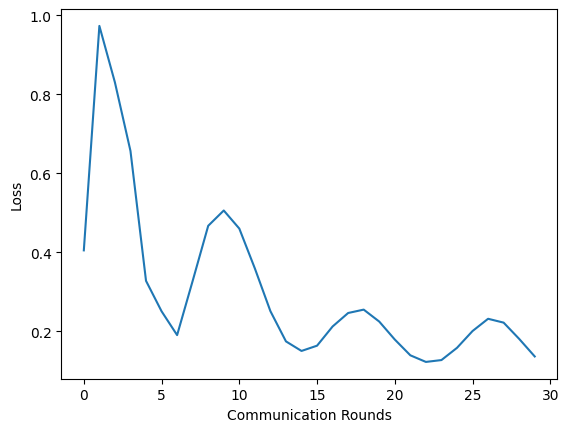

In [13]:
# ## Cell6: Federated Learning with Statistical Significance (Working Version)
import tensorflow as tf
import tensorflow_federated as tff
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import collections
from scipy import stats

# ======================
# 1. Data Preprocessing
# ======================

def preprocess(dataset):
    def batch_format_fn(features, labels):
        return collections.OrderedDict(
            x=tf.reshape(features, [-1, 40]),  # Flatten features
            y=tf.reshape(labels, [-1])  # Reshape labels
        )
    padded_shapes = ([None, 40], [None])
    return dataset.padded_batch(32, padded_shapes=padded_shapes).map(batch_format_fn).prefetch(tf.data.experimental.AUTOTUNE)


# ======================
# 2. Core FL Functions
# ======================

def create_keras_model():
    return tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(40,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

def make_federated_data(client_data, client_ids):
    """Create federated datasets from client data"""
    return [
        preprocess(client_data[i])
        for i in client_ids
        if len(list(client_data[i])) > 0  # Filter empty datasets
    ]

# ======================
# 3. Enhanced FL Training
# ======================

def run_fl_trial(seed=42, num_rounds=30):
    """Run complete FL pipeline with metrics tracking"""
    # Set all seeds
    tf.keras.utils.set_random_seed(seed)
    np.random.seed(seed)

    # Model function
    def model_fn():
        return tff.learning.models.from_keras_model(
            create_keras_model(),
            input_spec=federated_train_data[0].element_spec,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
        )

    # Build training process
    training_process = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.Adam(0.001),
        server_optimizer_fn=lambda: tf.keras.optimizers.Adam(0.01)
    )

    # Training loop
    state = training_process.initialize()
    train_losses = []

    for _ in range(num_rounds):
        result = training_process.next(state, federated_train_data)
        state = result.state
        train_losses.append(result.metrics['client_work']['train']['loss'])

    # Final evaluation
    eval_model = create_keras_model()
    eval_model.set_weights(training_process.get_model_weights(state).trainable)
    y_pred = np.argmax(eval_model.predict(test_features), axis=1)

    # Calculate additional metrics
    test_loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_test, eval_model.predict(test_features)
    ).numpy().mean()

    return {
        'train_loss': train_losses,
        'test_loss': test_loss,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'f1': f1_score(y_test, y_pred, average='macro', zero_division=0)
    }

# ======================
# 4. Execution & Analysis
# ======================

# Configuration
NUM_CLIENTS = 10
SEEDS = [42, 123, 456]

# Prepare federated data
federated_train_data = make_federated_data(train_datasets, list(range(NUM_CLIENTS)))

# Run multiple trials
fl_results = [run_fl_trial(seed=s) for s in SEEDS]

# Statistical comparison function
def print_stat_comparison(cl_results, fl_results):
    print("\n=== Statistical Significance ===")
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        cl_values = [r[f'test_{metric}'] for r in cl_results]
        fl_values = [r[metric] for r in fl_results]
        t_stat, p_value = stats.ttest_ind(cl_values, fl_values)

        print(f"\n{metric.upper():<10} CL: {np.mean(cl_values):.4f} ± {np.std(cl_values):.4f}")
        print(f"{'FL:':<10} {np.mean(fl_values):.4f} ± {np.std(fl_values):.4f}")
        print(f"{'p-value:':<10} {p_value:.4e}{'*' if p_value < 0.05 else ''}")

# Generate report
print_stat_comparison(results_cl, fl_results)

# Additional metrics visualization
print("\nTraining Loss Curve:")
plt.plot(fl_results[0]['train_loss'])
plt.xlabel('Communication Rounds')
plt.ylabel('Loss')
plt.show()

In [ ]:
# codes for all metrics (new)

In [9]:
# ## Cell5: Centralized Training (Full Metrics + Reporting)
import tensorflow as tf
import numpy as np
import pandas as pd
import time
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def centralized_training(seed=42, epochs=30):
    # Set seeds
    tf.keras.utils.set_random_seed(seed)
    np.random.seed(seed)
    start_time = time.time()

    # 1. Prepare data
    full_train = pd.concat(data_partitions).sample(frac=1, random_state=seed)
    X_train = full_train.drop('labels', axis=1).values.astype(np.float32)
    y_train = full_train['labels'].values.astype(np.int32)

    # 2. Model definition
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(40,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    # 3. Model size calculation
    model_size = sum([tf.size(w).numpy() for w in model.weights]) * 4 / (1024**2)  # MB

    # 4. Training with metrics callback
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    class PrintMetrics(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if (epoch+1) % 5 == 0:
                y_pred = np.argmax(model.predict(test_features), axis=1)
                print(f"\nEpoch {epoch+1}:")
                print(f"Train Loss: {logs['loss']:.4f} | Test Loss: {logs['val_loss']:.4f}")
                print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
                print(f"F1-Score: {f1_score(y_test, y_pred, average='macro'):.4f}")

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(test_features, test_labels),
        callbacks=[PrintMetrics()],
        verbose=0
    )

    # 5. Final metrics
    y_pred = np.argmax(model.predict(test_features), axis=1)
    train_rmse = np.sqrt(np.mean(np.square(history.history['loss'])))
    test_rmse = np.sqrt(np.mean(np.square(history.history['val_loss'])))

    return {
        'seed': seed,
        'time': time.time()-start_time,
        'model_size_mb': model_size,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro'),
        'recall': recall_score(y_test, y_pred, average='macro'),
        'f1': f1_score(y_test, y_pred, average='macro')
    }

# Run with 3 seeds
cl_results = [centralized_training(seed=s) for s in [42, 123, 456]]

705/705 [==============================] - 1s 2ms/step

Epoch 5:
Train Loss: 0.0260 | Test Loss: 0.7114
Accuracy: 0.9142
F1-Score: 0.7121
705/705 [==============================] - 2s 2ms/step

Epoch 10:
Train Loss: 0.0190 | Test Loss: 0.7805
Accuracy: 0.9269
F1-Score: 0.7333
705/705 [==============================] - 1s 2ms/step

Epoch 15:
Train Loss: 0.0148 | Test Loss: 0.8244
Accuracy: 0.9291
F1-Score: 0.7439
705/705 [==============================] - 1s 2ms/step

Epoch 20:
Train Loss: 0.0129 | Test Loss: 1.0537
Accuracy: 0.9299
F1-Score: 0.7547
705/705 [==============================] - 1s 2ms/step

Epoch 25:
Train Loss: 0.0124 | Test Loss: 1.0186
Accuracy: 0.9316
F1-Score: 0.7400
705/705 [==============================] - 2s 3ms/step

Epoch 30:
Train Loss: 0.0118 | Test Loss: 1.2363
Accuracy: 0.9299
F1-Score: 0.7289
705/705 [==============================] - 1s 2ms/step

Epoch 5:
Train Loss: 0.0276 | Test Loss: 0.6044
Accuracy: 0.9191
F1-Score: 0.7311
705/705 [====================

In [10]:
# ## Cell6: Federated Learning (Modified Code 2 – Fixed & Including Required Metrics)
import tensorflow as tf
import tensorflow_federated as tff
import numpy as np
import pandas as pd
import time
import collections
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ======================
# 1. Data Preprocessing
# ======================

def preprocess(dataset):
    def batch_format_fn(features, labels):
        return collections.OrderedDict(
            x=tf.reshape(features, [-1, 40]),  # Match input shape (40 features)
            y=tf.reshape(labels, [-1])
        )
    padded_shapes = ([None, 40], [None])
    return (
        dataset
        .padded_batch(32, padded_shapes=padded_shapes)
        .map(batch_format_fn)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )

# ======================
# 2. Model & Federated Data
# ======================

def create_keras_model():
    return tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(40,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

def make_federated_data(client_data, client_ids):
    return [
        preprocess(client_data[i])
        for i in client_ids
        if len(list(client_data[i])) > 0  # Skip any empty client dataset
    ]

# ======================
# 3. Federated Learning Trial
# ======================

def run_fl_trial(seed=42, num_rounds=30):
    tf.keras.utils.set_random_seed(seed)
    np.random.seed(seed)
    start_time = time.time()

    # Compute model size in MB
    temp_model = create_keras_model()
    model_size_bytes = sum([tf.size(w).numpy() for w in temp_model.weights]) * 4  # float32 → 4 bytes
    model_size_mb = model_size_bytes / (1024 ** 2)

    # Prepare federated data
    federated_train_data = make_federated_data(train_datasets, list(range(NUM_CLIENTS)))

    # Define model function for TFF (must create a *new* Keras model each time)
    def model_fn():
        keras_model = create_keras_model()
        return tff.learning.models.from_keras_model(
            keras_model,
            input_spec=federated_train_data[0].element_spec,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
        )

    # Build the Federated Averaging training process
    training_process = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.Adam(0.001),
        server_optimizer_fn=lambda: tf.keras.optimizers.Adam(0.01)
    )

    state = training_process.initialize()
    train_losses = []
    comm_cost_mb = 0.0

    # Training loop
    for round_num in range(num_rounds):
        result = training_process.next(state, federated_train_data)
        state = result.state

        # Capture the client training loss for this round
        current_train_loss = result.metrics['client_work']['train']['loss']
        train_losses.append(current_train_loss)

        # Communication cost: one download + one upload per client per round
        comm_cost_mb += model_size_mb * NUM_CLIENTS * 2

        # Every 5 rounds, evaluate on the global test set and print metrics
        if (round_num + 1) % 5 == 0:
            # Instantiate a fresh model and load the latest federated weights
            eval_model = create_keras_model()
            eval_model.set_weights(
                training_process.get_model_weights(state).trainable
            )

            # Compute predictions on the centralized test set
            y_logits = eval_model.predict(test_features)
            y_pred = np.argmax(y_logits, axis=1)
            y_true = y_test

            # Compute test loss manually
            test_loss = tf.keras.losses.sparse_categorical_crossentropy(
                y_true, y_logits
            ).numpy().mean()

            # Print round-wise metrics
            print(f"\n--- Round {round_num+1}/{num_rounds} ---")
            print(f"Train Loss (clients): {current_train_loss:.4f} | Test Loss: {test_loss:.4f}")
            print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f} | "
                  f"Precision: {precision_score(y_true, y_pred, average='macro', zero_division=0):.4f} | "
                  f"Recall: {recall_score(y_true, y_pred, average='macro', zero_division=0):.4f} | "
                  f"F1-Score: {f1_score(y_true, y_pred, average='macro', zero_division=0):.4f}")

    # Final evaluation after all rounds
    eval_model = create_keras_model()
    eval_model.set_weights(
        training_process.get_model_weights(state).trainable
    )
    final_logits = eval_model.predict(test_features)
    final_pred = np.argmax(final_logits, axis=1)
    final_test_loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_test, final_logits
    ).numpy().mean()

    return {
        'train_time_sec': time.time() - start_time,
        'model_size_mb': model_size_mb,
        'comm_cost_mb': comm_cost_mb,
        'train_losses': train_losses,
        'final_test_loss': final_test_loss,
        'accuracy': accuracy_score(y_test, final_pred),
        'precision': precision_score(y_test, final_pred, average='macro', zero_division=0),
        'recall': recall_score(y_test, final_pred, average='macro', zero_division=0),
        'f1': f1_score(y_test, final_pred, average='macro', zero_division=0)
    }

# ======================
# 4. Execution & Statistical Comparison
# ======================

# Configuration (must match the centralized setup)
NUM_CLIENTS = 10
SEEDS = [42, 123, 456]

# Create federated datasets once before running trials
federated_train_data = make_federated_data(train_datasets, list(range(NUM_CLIENTS)))

# Run FL trials for each seed
fl_results = [run_fl_trial(seed=s) for s in SEEDS]

# Statistical comparison with centralized results (cl_results must already exist)
from scipy import stats

def print_comparison(cl_res, fl_res):
    print("\n=== CL vs FL Comparison ===")
    print(f"{'Metric':<15} {'CL Mean±Std':<25} {'FL Mean±Std':<25} {'p-value':<10}")
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        cl_vals = [r[f'test_{metric}'] for r in cl_res]
        fl_vals = [r[metric] for r in fl_res]
        t_stat, p_val = stats.ttest_ind(cl_vals, fl_vals)
        print(f"{metric.capitalize():<15} "
              f"{np.mean(cl_vals):.4f}±{np.std(cl_vals):.4f} | "
              f"{np.mean(fl_vals):.4f}±{np.std(fl_vals):.4f} | "
              f"{p_val:.2e}{'*' if p_val < 0.05 else ''}")

# Call the comparison function
print_comparison(cl_results, fl_results)


705/705 [==============================] - 1s 2ms/step

--- Round 5/30 ---
Train Loss (clients): 0.5390 | Test Loss: 1.5603
Accuracy: 0.7190 | Precision: 0.2917 | Recall: 0.3403 | F1-Score: 0.3092
705/705 [==============================] - 1s 2ms/step

--- Round 10/30 ---
Train Loss (clients): 0.4025 | Test Loss: 1.5751
Accuracy: 0.8046 | Precision: 0.3309 | Recall: 0.3716 | F1-Score: 0.3481
705/705 [==============================] - 2s 3ms/step

--- Round 15/30 ---
Train Loss (clients): 0.2621 | Test Loss: 1.4434
Accuracy: 0.7308 | Precision: 0.2988 | Recall: 0.3474 | F1-Score: 0.3146
705/705 [==============================] - 1s 2ms/step

--- Round 20/30 ---
Train Loss (clients): 0.4005 | Test Loss: 1.7424
Accuracy: 0.7871 | Precision: 0.3377 | Recall: 0.3609 | F1-Score: 0.3426
705/705 [==============================] - 1s 2ms/step

--- Round 25/30 ---
Train Loss (clients): 0.2505 | Test Loss: 1.3001
Accuracy: 0.7988 | Precision: 0.4691 | Recall: 0.3752 | F1-Score: 0.3474
705/705 [==

KeyError: 'test_accuracy'

In [11]:
# ======================
# 4. Execution & Statistical Comparison (Corrected)
# ======================

from scipy import stats

def print_comparison(cl_res, fl_res):
    """
    Compare centralized (CL) vs. federated (FL) metrics using a two‐sample t‐test.
    Assumes that each entry in `cl_res` and `fl_res` dictionaries
    already contains keys: 'accuracy', 'precision', 'recall', 'f1'.
    """
    print("\n=== CL vs FL Comparison ===")
    print(f"{'Metric':<15} {'CL Mean±Std':<25} {'FL Mean±Std':<25} {'p-value':<10}")
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        cl_vals = [r[metric] for r in cl_res]    # <-- use 'accuracy', not 'test_accuracy'
        fl_vals = [r[metric] for r in fl_res]
        t_stat, p_val = stats.ttest_ind(cl_vals, fl_vals)
        print(
            f"{metric.capitalize():<15} "
            f"{np.mean(cl_vals):.4f}±{np.std(cl_vals):.4f} | "
            f"{np.mean(fl_vals):.4f}±{np.std(fl_vals):.4f} | "
            f"{p_val:.2e}{'*' if p_val < 0.05 else ''}"
        )

# Call the corrected comparison function:
print_comparison(cl_results, fl_results)



=== CL vs FL Comparison ===
Metric          CL Mean±Std               FL Mean±Std               p-value   
Accuracy        0.9294±0.0036 | 0.8274±0.0031 | 6.68e-06*
Precision       0.9069±0.0399 | 0.4109±0.0965 | 2.56e-03*
Recall          0.6959±0.0223 | 0.3839±0.0025 | 3.92e-05*
F1              0.7386±0.0223 | 0.3619±0.0043 | 1.95e-05*


In [13]:
# Assuming you have already run:
# cl_results = [centralized_training(seed=s) for s in SEEDS]
# fl_results = [run_fl_trial(seed=s)          for s in SEEDS]

print("=== Centralized Learning Results ===")
for idx, seed in enumerate(SEEDS):
    cl = cl_results[idx]
    print(f"\n-- Seed {seed} --")
    # Training time
    print(f"Training Time (sec):   {cl['time']:.2f}")
    # Model size
    print(f"Model Size (MB):       {cl['model_size_mb']:.4f}")
    # (No communication cost in CL)
    # Training RMSE and Test RMSE
    print(f"Train RMSE:            {cl['train_rmse']:.4f}")
    print(f"Test  RMSE:            {cl['test_rmse']:.4f}")
    # Accuracy, Precision, Recall, F1
    print(f"Accuracy:              {cl['accuracy']:.4f}")
    print(f"Precision:             {cl['precision']:.4f}")
    print(f"Recall:                {cl['recall']:.4f}")
    print(f"F1-Score:              {cl['f1']:.4f}")

print("\n=== Federated Learning Results ===")
for idx, seed in enumerate(SEEDS):
    fl = fl_results[idx]
    print(f"\n-- Seed {seed} --")
    # Training time
    print(f"Training Time (sec):   {fl['train_time_sec']:.2f}")
    # Model size
    print(f"Model Size (MB):       {fl['model_size_mb']:.4f}")
    # Communication cost
    print(f"Comm. Cost (MB):       {fl['comm_cost_mb']:.2f}")
    # If you want final train loss instead of the whole curve:
    last_train_loss = fl['train_losses'][-1]
    print(f"Final Train Loss:      {last_train_loss:.4f}")
    # Final test loss
    print(f"Final Test Loss:       {fl['final_test_loss']:.4f}")
    # Accuracy, Precision, Recall, F1
    print(f"Accuracy:              {fl['accuracy']:.4f}")
    print(f"Precision:             {fl['precision']:.4f}")
    print(f"Recall:                {fl['recall']:.4f}")
    print(f"F1-Score:              {fl['f1']:.4f}")


=== Centralized Learning Results ===

-- Seed 42 --
Training Time (sec):   365.63
Model Size (MB):       0.0528
Train RMSE:            0.0269
Test  RMSE:            0.8993
Accuracy:              0.9299
Precision:             0.9533
Recall:                0.6707
F1-Score:              0.7289

-- Seed 123 --
Training Time (sec):   385.55
Model Size (MB):       0.0528
Train RMSE:            0.0292
Test  RMSE:            0.8213
Accuracy:              0.9248
Precision:             0.8558
Recall:                0.6922
F1-Score:              0.7175

-- Seed 456 --
Training Time (sec):   347.56
Model Size (MB):       0.0528
Train RMSE:            0.0284
Test  RMSE:            0.6935
Accuracy:              0.9335
Precision:             0.9118
Recall:                0.7248
F1-Score:              0.7695

=== Federated Learning Results ===

-- Seed 42 --
Training Time (sec):   78.58
Model Size (MB):       0.0528
Comm. Cost (MB):       31.65
Final Train Loss:      0.2731
Final Test Loss:       1.29

In [16]:
import numpy as np
from scipy import stats

def print_cl_vs_fl(cl_res, fl_res):
    """
    Given:
      - cl_res: list of dicts returned by centralized_training(...)
                each dict has keys: 'accuracy', 'precision', 'recall', 'f1', etc.
      - fl_res: list of dicts returned by run_fl_trial(...)
                each dict has keys: 'accuracy', 'precision', 'recall', 'f1', etc.
    This function prints a table of mean±std for CL vs FL (across seeds)
    and the two‐sample t‐test p-value for each metric. A '*' is appended
    if p < 0.05.
    """
    print("\n=== CL vs FL Comparison ===")
    print(f"{'Metric':<15} {'CL Mean±Std':<25} {'FL Mean±Std':<25} {'p-value':<10}")
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        # Extract the list of values across seeds
        cl_vals = np.array([r[metric] for r in cl_res])
        fl_vals = np.array([r[metric] for r in fl_res])
        # Compute means and standard deviations
        cl_mean, cl_std = cl_vals.mean(), cl_vals.std(ddof=0)
        fl_mean, fl_std = fl_vals.mean(), fl_vals.std(ddof=0)
        # Perform two‐sample t‐test (independent)
        t_stat, p_val = stats.ttest_ind(cl_vals, fl_vals)
        star = '*' if p_val < 0.05 else ''
        # Print formatted
        print(
            f"{metric.capitalize():<15} "
            f"{cl_mean:.4f}±{cl_std:.4f} | "
            f"{fl_mean:.4f}±{fl_std:.4f} | "
            f"{p_val:.2e}{star}"
        )



# Call it:
print_cl_vs_fl(cl_results, fl_results)



=== CL vs FL Comparison ===
Metric          CL Mean±Std               FL Mean±Std               p-value   
Accuracy        0.9294±0.0036 | 0.8274±0.0031 | 6.68e-06*
Precision       0.9069±0.0399 | 0.4109±0.0965 | 2.56e-03*
Recall          0.6959±0.0223 | 0.3839±0.0025 | 3.92e-05*
F1              0.7386±0.0223 | 0.3619±0.0043 | 1.95e-05*


In [19]:
import numpy as np
from scipy import stats

print("\n=== CL vs FL Comparison (Additional + Train Loss) ===")
print(f"{'Metric':<30} {'CL Mean±Std':<25} {'FL Mean±Std':<25} {'p-value':<10}")

# 1) Train Loss: CL uses 'train_rmse'; FL uses last element of 'train_losses'
cl_train_losses = np.array([r['train_rmse'] for r in cl_results])
fl_train_losses = np.array([r['train_losses'][-1] for r in fl_results])
cl_mean, cl_std = cl_train_losses.mean(), cl_train_losses.std(ddof=0)
fl_mean, fl_std = fl_train_losses.mean(), fl_train_losses.std(ddof=0)
t_stat, p_val = stats.ttest_ind(cl_train_losses, fl_train_losses)
star = '*' if p_val < 0.05 else ''
print(
    f"{'Train Loss':<30} "
    f"{cl_mean:.4f}±{cl_std:.4f} | "
    f"{fl_mean:.4f}±{fl_std:.4f} | "
    f"{p_val:.2e}{star}"
)

# 2) Training Time: CL key='time'; FL key='train_time_sec'
cl_times = np.array([r['time'] for r in cl_results])
fl_times = np.array([r['train_time_sec'] for r in fl_results])
cl_mean, cl_std = cl_times.mean(), cl_times.std(ddof=0)
fl_mean, fl_std = fl_times.mean(), fl_times.std(ddof=0)
t_stat, p_val = stats.ttest_ind(cl_times, fl_times)
star = '*' if p_val < 0.05 else ''
print(
    f"{'Training Time (sec)':<30} "
    f"{cl_mean:.4f}±{cl_std:.4f} | "
    f"{fl_mean:.4f}±{fl_std:.4f} | "
    f"{p_val:.2e}{star}"
)

# 3) Model Size (MB): both use 'model_size_mb'
cl_models = np.array([r['model_size_mb'] for r in cl_results])
fl_models = np.array([r['model_size_mb'] for r in fl_results])
cl_mean, cl_std = cl_models.mean(), cl_models.std(ddof=0)
fl_mean, fl_std = fl_models.mean(), fl_models.std(ddof=0)
t_stat, p_val = stats.ttest_ind(cl_models, fl_models)
star = '*' if p_val < 0.05 else ''
print(
    f"{'Model Size (MB)':<30} "
    f"{cl_mean:.4f}±{cl_std:.4f} | "
    f"{fl_mean:.4f}±{fl_std:.4f} | "
    f"{p_val:.2e}{star}"
)

# 4) Test Loss: CL uses 'test_rmse'; FL uses 'final_test_loss'
cl_test_losses = np.array([r['test_rmse'] for r in cl_results])
fl_test_losses = np.array([r['final_test_loss'] for r in fl_results])
cl_mean, cl_std = cl_test_losses.mean(), cl_test_losses.std(ddof=0)
fl_mean, fl_std = fl_test_losses.mean(), fl_test_losses.std(ddof=0)
t_stat, p_val = stats.ttest_ind(cl_test_losses, fl_test_losses)
star = '*' if p_val < 0.05 else ''
print(
    f"{'Test Loss':<30} "
    f"{cl_mean:.4f}±{cl_std:.4f} | "
    f"{fl_mean:.4f}±{fl_std:.4f} | "
    f"{p_val:.2e}{star}"
)



=== CL vs FL Comparison (Additional + Train Loss) ===
Metric                         CL Mean±Std               FL Mean±Std               p-value   
Train Loss                     0.0282±0.0009 | 0.1729±0.0717 | 4.62e-02*
Training Time (sec)            366.2462±15.5169 | 74.5495±2.9060 | 1.27e-05*
Model Size (MB)                0.0528±0.0000 | 0.0528±0.0000 | nan
Test Loss                      0.8047±0.0849 | 0.9075±0.2889 | 6.55e-01


<ipython-input-19-d0bf10934036>:40: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(cl_models, fl_models)
